**классификатор изображений на основе свёрточной сети**

Евгений Борисов <esborisov@sevsu.ru>

---

Backpropagation applied to handwritten zip code recognition.    
LeCun Y., Boser B., Denker J.S., Henderson D., Howard R.E., Hubbard W., Jackel L.D.   
Neural Computation 1989 1(4):541-551.  

http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf   

---

In [1]:
import numpy as np
import numpy.random as rng
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
torch.__version__

'1.10.2+cu102'

In [4]:
torchvision.__version__

'0.11.3+cu102'

## данные

In [5]:
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(( 0.5), ( 0.5))
    ])

batch_size = 1024

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
# images, labels = iter(trainloader).next()
# images.shape

In [7]:
# images.numpy()[0,0,:]

In [8]:
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [9]:
class_names = [ 'футболка', 
                'брюки', 
                'свитер', 
                'платье', 
                'пальто', 
                'сандали', 
                'рубашка', 
                'тапки', 
                'сумка', 
                'ботинки', ]

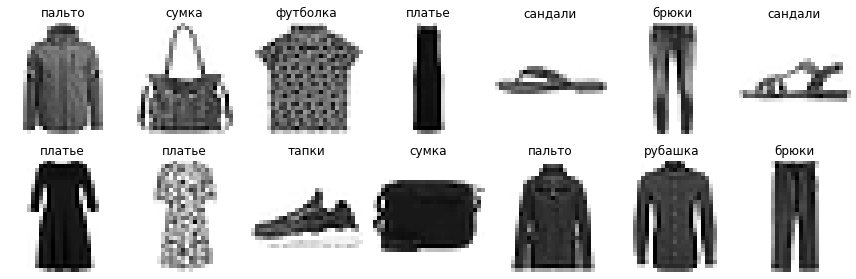

In [12]:
def tensor2img(images):
    x = np.transpose( images, (0, 2, 3, 1))
    return ((x-x.min())/(x.max()-x.min())*255.).astype(np.uint8)


def plot_samples( images, labels, n_show=14,columns=7,cmap='gray_r' ):
    X = tensor2img( images.numpy() )
    ii = np.random.permutation(X.shape[0])[:n_show]
    fig = plt.figure(figsize=(12,2*(n_show//columns+1)))
    for n,i in enumerate(ii):
        plt.subplot( n_show//columns+1, columns, n+1)
        plt.axis(False)
        plt.title( class_names[ labels.numpy()[i] ] )
        plt.imshow(X[i,:],cmap=cmap)
    fig.tight_layout()

images, labels = iter(trainloader).next()
plot_samples(images,labels)

## модель

In [13]:
_,img_nch, img_h, img_w = images.shape
img_nch,img_h, img_w

(1, 28, 28)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=img_nch, out_channels=8, kernel_size=(3,3))
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=16*9*9, out_features=120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        # print(x.shape)
        x = F.relu(self.conv1(x))
        # print(x.shape)
        x = self.pool(x)
        # print(x.shape)
        x = F.relu(self.conv2(x))
        # print(x.shape)
        #x = self.pool(x)
        # print(x.shape)
        x = x.view(-1, 16*9*9)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x),dim=1)
        return x

In [16]:
model = ConvNet()
model

ConvNet(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1296, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=10, bias=True)
)

In [19]:
# !pip3 install torchsummary

In [20]:
from torchsummary import summary

summary(model, (1, 28, 28),device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
         MaxPool2d-2            [-1, 8, 13, 13]               0
            Conv2d-3             [-1, 16, 9, 9]           3,216
            Linear-4                  [-1, 120]         155,640
            Linear-5                   [-1, 10]           1,210
Total params: 160,146
Trainable params: 160,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.61
Estimated Total Size (MB): 0.68
----------------------------------------------------------------


In [21]:
# model(images).shape

## обучаем

In [22]:
import torch.optim as optim

In [23]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001) # , momentum=0.9)
# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.001) # , momentum=0.9)


In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [25]:
model = model.to(device)

In [26]:
%%time

loss_hist = []

for epoch in range(10):  # loop over the dataset multiple times

    for i, (images, labels)  in enumerate(trainloader, 0):
        images, labels = images.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        loss_hist.append( loss.item() )
        
        if i % 10 == 0:    # print every N mini-batches
            print('%d/%d loss: %.3f' %(epoch + 1, i + 1,  loss.item() ))
                
        del images
        del labels

1/1 loss: 2.302
1/11 loss: 2.156
1/21 loss: 1.936
1/31 loss: 1.868
1/41 loss: 1.829
1/51 loss: 1.756
2/1 loss: 1.724
2/11 loss: 1.718
2/21 loss: 1.711
2/31 loss: 1.708
2/41 loss: 1.695
2/51 loss: 1.681
3/1 loss: 1.680
3/11 loss: 1.670
3/21 loss: 1.646
3/31 loss: 1.657
3/41 loss: 1.660
3/51 loss: 1.663
4/1 loss: 1.660
4/11 loss: 1.639
4/21 loss: 1.623
4/31 loss: 1.645
4/41 loss: 1.658
4/51 loss: 1.634
5/1 loss: 1.645
5/11 loss: 1.620
5/21 loss: 1.658
5/31 loss: 1.649
5/41 loss: 1.606
5/51 loss: 1.619
6/1 loss: 1.608
6/11 loss: 1.607
6/21 loss: 1.622
6/31 loss: 1.605
6/41 loss: 1.605
6/51 loss: 1.622
7/1 loss: 1.615
7/11 loss: 1.605
7/21 loss: 1.614
7/31 loss: 1.628
7/41 loss: 1.592
7/51 loss: 1.608
8/1 loss: 1.588
8/11 loss: 1.588
8/21 loss: 1.598
8/31 loss: 1.596
8/41 loss: 1.601
8/51 loss: 1.615
9/1 loss: 1.592
9/11 loss: 1.593
9/21 loss: 1.598
9/31 loss: 1.598
9/41 loss: 1.584
9/51 loss: 1.602
10/1 loss: 1.596
10/11 loss: 1.593
10/21 loss: 1.591
10/31 loss: 1.620
10/41 loss: 1.597
10

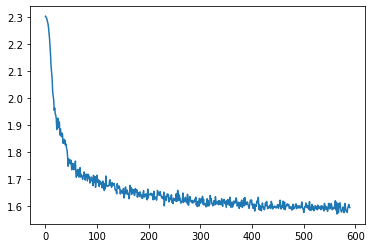

In [27]:
plt.plot(loss_hist)

## тест

In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [29]:
label = []
score = []
images = []
with torch.no_grad():
    for x,y in testloader:
        x, y = x.to(device), y.to(device)
        o = model(x)
        label.append( y.cpu().detach().numpy() )
        score.append( o.cpu().detach().numpy() )
        images.append(x.cpu().detach().numpy() ) 
        del x
        del y

In [30]:
# class_names

In [31]:
label = np.hstack(label)
score = np.vstack(score)
images = tensor2img( np.vstack(images) )

In [32]:
y_pred = np.argmax( score ,axis=1)
accuracy_score(label, y_pred)
# print(classification_report(label, y_pred) )

0.8586

In [33]:
import pandas as pd

t = [ 
 [ c.strip() for c in l.split('  ') if c ]
 for l in classification_report(label, y_pred).split('\n') if l 
]

h = ['class'] + t[0]
t = t[1:]
t[-3].insert(1,' ')
t[-3].insert(1,' ')


df = pd.DataFrame(t,columns=h )
df['name'] = [ class_names[ int(c[0]) ] for c in t[:-3]  ]+[' ']*3
df[['class','name','precision','recall','f1-score','support',]]

,class,name,precision,recall,f1-score,support
0,0,футболка,0.73,0.88,0.80,1000
1,1,брюки,0.99,0.96,0.97,1000
2,2,свитер,0.73,0.87,0.79,1000
3,3,платье,0.84,0.90,0.87,1000
4,4,пальто,0.83,0.71,0.77,1000
5,5,сандали,0.98,0.93,0.95,1000
6,6,рубашка,0.68,0.48,0.56,1000
7,7,тапки,0.91,0.95,0.93,1000
8,8,сумка,0.95,0.96,0.96,1000
9,9,ботинки,0.94,0.95,0.94,1000


In [34]:
# images.shape

In [35]:
predict = np.argmax(score,axis=1)

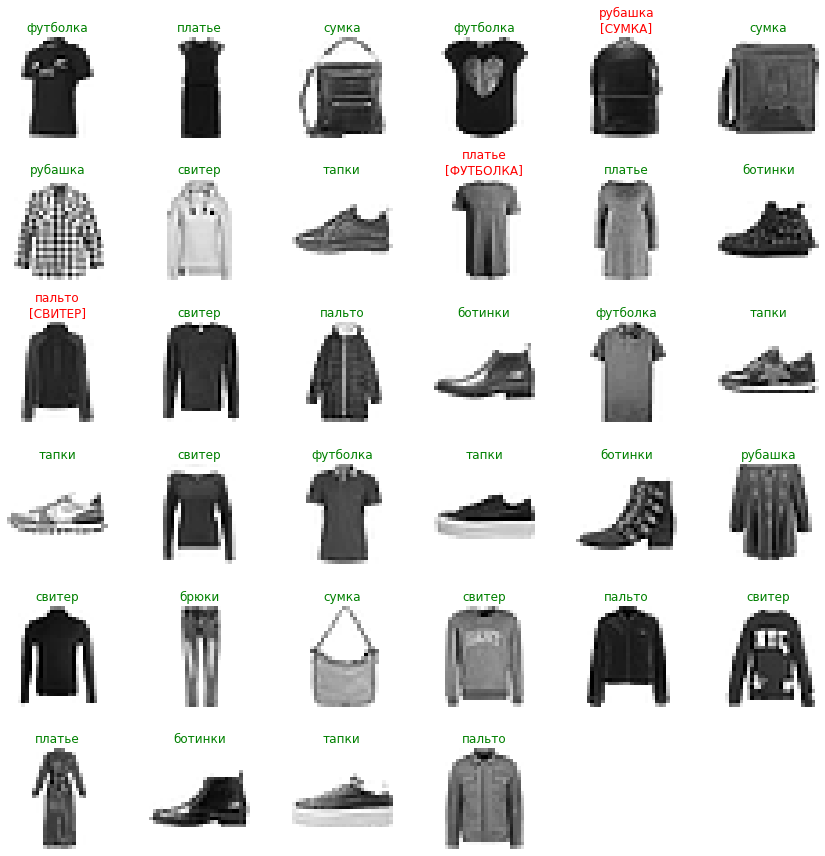

In [36]:
def plot_samples( images, labels, predict, n_show=34, columns=6,cmap='gray_r', class_names=class_names ):
    ii = np.random.permutation(images.shape[0])[:n_show]
    fig = plt.figure(figsize=(2*columns,2*(n_show //columns+1)))
    for n,i in enumerate(ii):
        plt.subplot( n_show//columns+1, columns, n+1)
        plt.axis(False)
        
        t = (
            class_names[ labels[i] ] 
            if labels[i]==predict[i] 
            else '%s\n[%s]'%( class_names[ predict[i] ] , class_names[ labels[i] ].upper() ) 
        )
                    
        c = 'g' if labels[i]==predict[i] else 'r'
        
        plt.title( t,color=c )
        plt.imshow(images[i,:],cmap=cmap)
    fig.tight_layout()
        

plot_samples( images, label, predict)